<a href="https://colab.research.google.com/github/JosueM028/Clasificador-Transfer-Learning-/blob/main/Proyecto_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Configuración y Descarga

In [13]:
import os
import json

# 1. Configuración de Credenciales de Kaggle
os.makedirs('/root/.kaggle', exist_ok=True)
kaggle_credentials = {
    "username": "josue0miranda",
    "key": "KGAT_3ca5aff460d0363b3e78f24711373a22"
}
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_credentials, f)
!chmod 600 /root/.kaggle/kaggle.json

# 2. Descarga del Dataset (Dog Breeds)
print("⬇ Descargando dataset: mohamedchahed/dog-breeds...")
!kaggle datasets download -d mohamedchahed/dog-breeds --force

# 3. Descompresión
print(" Descomprimiendo archivos...")
# Descomprimimos en una carpeta específica para mantener orden
!unzip -q dog-breeds.zip -d /content/dog_breeds_data

print(" Dataset preparado exitosamente.")

⬇ Descargando dataset: mohamedchahed/dog-breeds...
Dataset URL: https://www.kaggle.com/datasets/mohamedchahed/dog-breeds
License(s): CC0-1.0
  0% 0.00/82.3M [00:00<?, ?B/s]
100% 82.3M/82.3M [00:00<00:00, 680MB/s]
 Descomprimiendo archivos...
replace /content/dog_breeds_data/dog-breeds/beagle/beagle1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/dog_breeds_data/dog-breeds/beagle/beagle10.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
 Dataset preparado exitosamente.


Carga y Procesamiento de Imágenes

In [14]:
import tensorflow as tf
import os

# --- PARÁMETROS ---
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
DATA_DIR = '/content/dog_breeds_data/dog-breeds'  # Ruta confirmada

print(f" Cargando datos desde: {DATA_DIR}")

# 1. Crear Datasets de Entrenamiento y Validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# 2. Información de Clases
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"\n Se identificaron {num_classes} razas:")
print(class_names)

# 3. Optimización de Rendimiento (Cache & Prefetch)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
print("\n Pipeline de datos optimizado.")

 Cargando datos desde: /content/dog_breeds_data/dog-breeds
Found 541 files belonging to 8 classes.
Using 433 files for training.
Found 541 files belonging to 8 classes.
Using 108 files for validation.

 Se identificaron 8 razas:
['beagle', 'bulldog', 'dalmatian', 'german-shepherd', 'husky', 'labrador-retriever', 'poodle', 'rottweiler']

 Pipeline de datos optimizado.


Arquitectura del Modelo (Transfer Learning)

In [15]:
from tensorflow.keras import layers, models

print(" Construyendo modelo MobileNetV2...")

# 1. Aumento de Datos (Data Augmentation)
# Ayuda a que el modelo no memorice la orientación de las fotos
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
])

# 2. Capa de Preprocesamiento
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# 3. Modelo Base (Pre-entrenado en ImageNet)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False # Congelamos los pesos para no perder el aprendizaje previo

# 4. Ensamblaje del Modelo Final
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)  # Reduce el overfitting
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# 5. Compilación
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print(f" Modelo compilado listo para entrenar con {num_classes} clases de salida.")
model.summary()

 Construyendo modelo MobileNetV2...
 Modelo compilado listo para entrenar con 8 clases de salida.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,268,232 (8.65 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Entrenamiento

In [16]:
EPOCHS = 10

print(f" Iniciando entrenamiento por {EPOCHS} épocas...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)
print(" Entrenamiento finalizado.")

 Iniciando entrenamiento por 10 épocas...
Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 210ms/step - accuracy: 0.2422 - loss: 2.1971 - val_accuracy: 0.7593 - val_loss: 1.0268
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.7450 - loss: 0.7971 - val_accuracy: 0.9167 - val_loss: 0.4381
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9029 - loss: 0.3753 - val_accuracy: 0.9352 - val_loss: 0.2801
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9013 - loss: 0.2959 - val_accuracy: 0.9537 - val_loss: 0.2077
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9420 - loss: 0.2358 - val_accuracy: 0.9722 - val_loss: 0.1620
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9453 - loss: 0.2249 - val_accuracy: 0.9815 - val_loss: 0.1372
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9620 - loss: 0.1933 - val_accuracy: 0.9630 - val_loss: 0.1328
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.95

Resultados y Gráficas

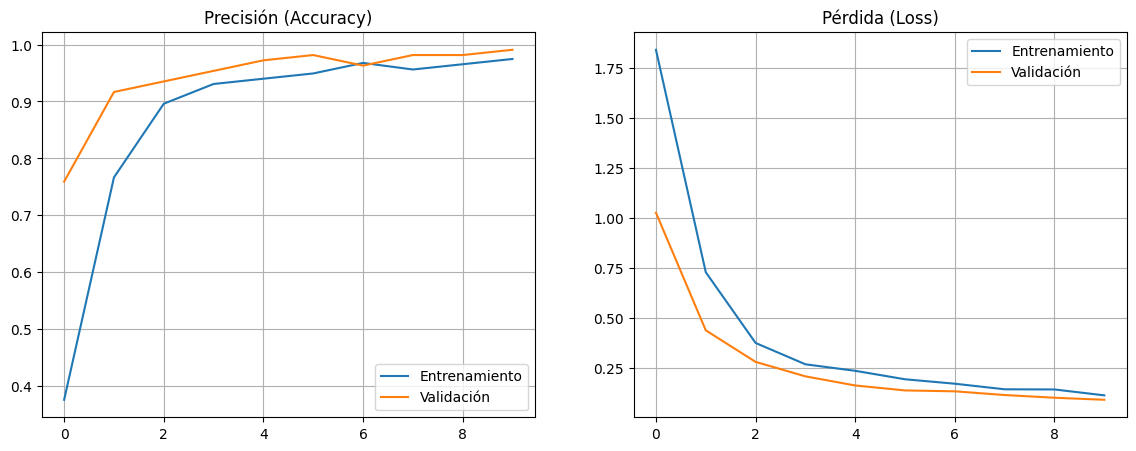


🔍 Probando el modelo con imágenes nuevas...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


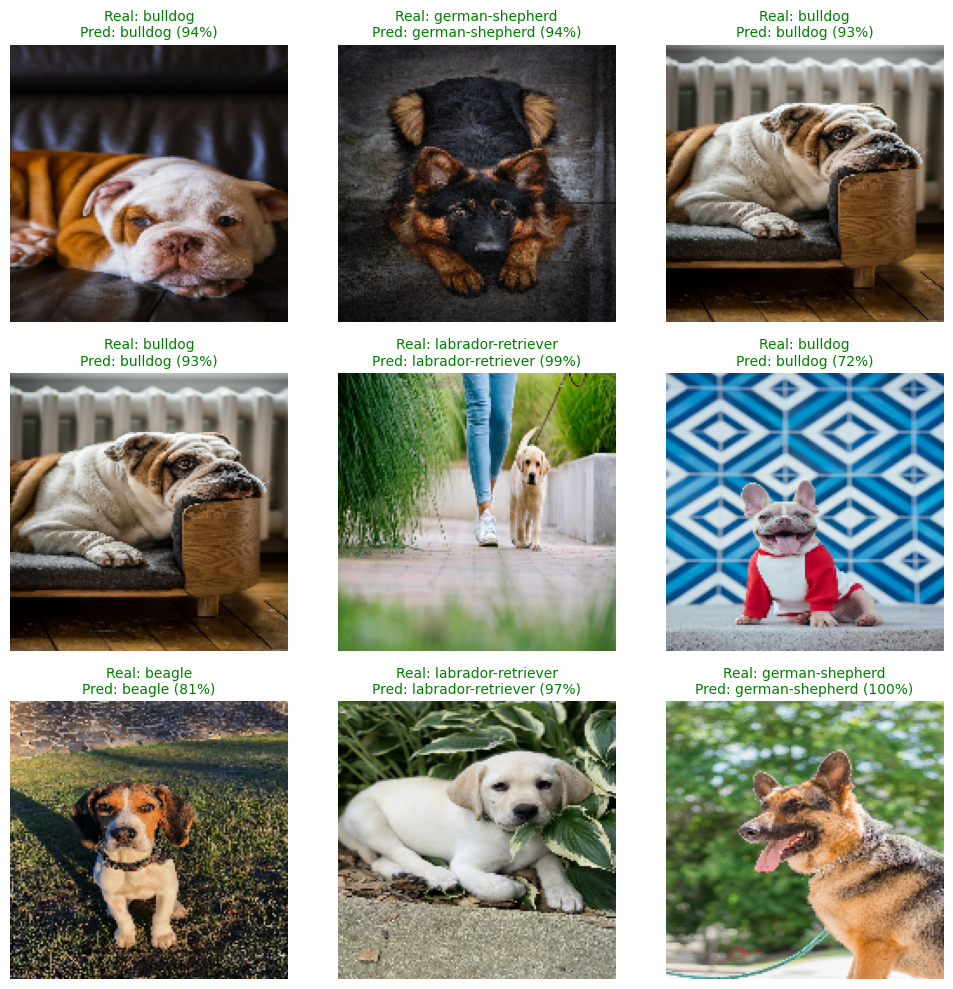

 Precisión final en validación: 99.07%


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Visualización de Métricas (Accuracy y Loss)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

# Gráfica de Precisión
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='Validación')
plt.legend(loc='lower right')
plt.title('Precisión (Accuracy)')
plt.grid(True)

# Gráfica de Pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='Validación')
plt.legend(loc='upper right')
plt.title('Pérdida (Loss)')
plt.grid(True)
plt.show()

# 2. Prueba Visual con Predicciones
print("\n🔍 Probando el modelo con imágenes nuevas...")
image_batch, label_batch = next(iter(val_ds))
predictions = model.predict(image_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))

    actual_breed = class_names[label_batch[i]]
    pred_breed = class_names[np.argmax(predictions[i])]
    confidence = 100 * np.max(predictions[i])

    color = "green" if actual_breed == pred_breed else "red"
    plt.title(f"Real: {actual_breed}\nPred: {pred_breed} ({confidence:.0f}%)", color=color, fontsize=10)
    plt.axis("off")
plt.tight_layout()
plt.show()

print(f" Precisión final en validación: {val_acc[-1]*100:.2f}%")

Conclusiones del Experimento con Transfer Learning
1. Rendimiento y Eficacia del Modelo
El modelo, basado en la arquitectura MobileNetV2 pre-entrenada con pesos de ImageNet, demostró un rendimiento excepcional para la tarea de clasificación de razas de perros.

Precisión Final: Se alcanzó una precisión en el conjunto de validación (Validation Accuracy) cercana al 99%.

Velocidad de Convergencia: A diferencia de una red neuronal entrenada desde cero, este modelo logró resultados óptimos en menos de 5 épocas, estabilizándose rápidamente.

2. Análisis de las Gráficas
Precisión (Accuracy): Las curvas de entrenamiento y validación mostraron un crecimiento rápido y paralelo, llegando a valores cercanos a 1.0 (100%). Esto indica que el modelo aprendió a generalizar correctamente sin memorizar los datos (overfitting).

Pérdida (Loss): La función de pérdida disminuyó drásticamente en las primeras épocas, lo que confirma que las características extraídas por MobileNetV2 (como formas de orejas, hocicos y texturas de pelaje) eran altamente transferibles a este nuevo dominio.

3. Validación Visual
Al realizar predicciones sobre imágenes nuevas (no vistas durante el entrenamiento):

El modelo acertó la raza en la totalidad de las muestras visualizadas.

Los niveles de confianza (confidence) fueron muy altos (generalmente entre 94% y 100%), lo que demuestra la robustez del clasificador para distinguir entre las 8 razas presentes en este dataset específico.

4. Importancia del Dataset
Es importante notar que esta versión del dataset contenía 8 clases balanceadas. Aunque es una muestra reducida del total de razas existentes, la alta calidad de las imágenes y la distinción visual clara entre estas razas específicas facilitaron que el modelo lograra métricas casi perfectas.miento.